### Satellite pre-processing 
### For high-resolution air temperature downscaling

In this notebook we show how the meteoblue satellite pre-processing works. Satellite-derived surface properties are needed as input fields for the high-resolution model (mCCM) of meteoblue which allows to resolve air temperature fields in urban areas with a horizontal resolution of 10 meters.

**What are we doing?** </p>
We are going to produce a satellite dataset step-by-step for the urban area of **Ljubljana, Slovenia**.

**Data basis** </p>
For the satellite processing, we need data from the polar-orbiting satellite **Sentinel-2** (ESA).
The data can be found under the following links:
- [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home)

In this notebook, we are deriving the raw data with **eo-learn**.

For the satellite processing it is **important** that
- the sensing date of the satellite scenes are in the summer of the respective hemisphere
- the satellite scene is cloud-free in the area of interest.

**Derived satellite properties** </p>
We derive several satellite properties which are providing information about the surface structure within urban areas. These properties are the main predictors within the mCCM (meteoblue city-climate model) and enable to resolve the small-scale air temperature variability.

We derive the following satellite properties from Sentinel-2:
- NDVI (Normalized Difference Vegetation Index)
- NDBI (Normalized Difference Build-up Index)
- NDWI (Normalized Difference Water Index)
- Albedo

In [1]:
# Load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions.sentinel2_utils import *
from functions.eo_learn_download import *

# eo-learn modules
from eolearn.visualization import PlotConfig

# Sentinelhub modules
from sentinelhub import SHConfig

/Users/nicobader/opt/anaconda3/envs/mccm_sat/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup ID and secret for Sentinelhub 
CLIENT_ID = ""
CLIENT_SECRET = ""

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == "" or config.sh_client_secret == "" or config.instance_id == "":
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

config.save()

Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).


#### Define input
You have to define the following input information:
- **Name of the city**/urban area ("*city*")
- The **bounding box** for your area of interest ("*bbox_wgs84*") in the following format:
(lon_min, lat_min, lon_max, lat_max)
- **Time window** in which satellite scenes will be searched

In [3]:
# Define the name of the City
city = "Ljubljana"

# Define bounding box (lon_min, lat_min, lon_max, lat_max)
bbox_wgs84 = [14.4, 46.0, 14.6, 46.15]

# Define time window in which satellite images should be searched for
start = "2022-06-13"
end = "2022-06-15"

#### Download Sentinel-2 data
- Request Sentinel API for defined
    - Time window
    - Bounding Box

In [4]:
# Get Sentinel-2 data
eopatch_s2_l1c = eo_learn_get_sentinel2_l1c(bbox_wgs84, start, end)

#### Plot satellite scene

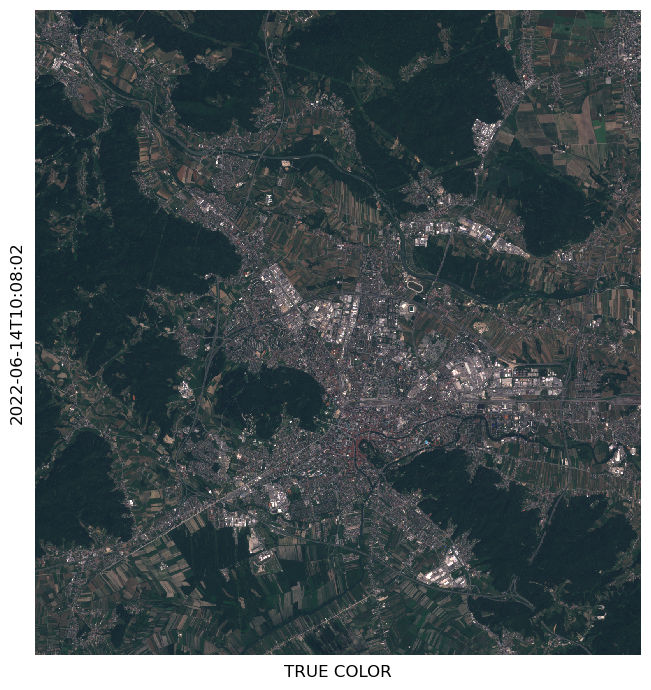

In [5]:
# Plot satellite scene as RGB image
# configure the plotting
plot_config = PlotConfig(subplot_width=7, subplot_height=7, rgb_factor=2.5, show_title=False)

eopatch_s2_l1c.plot(
    (FeatureType.DATA, "L1C_data"), times=[0], rgb=[3, 2, 1], channel_names=["TRUE COLOR"], config=plot_config
);


#### Sentinel-2 data processing
**I) Project the Sentinel-2 grid in the default map projection.** </p>
- Sentinel-2 images are projected in UTM (Universal Transverse Mercator) coordinates.
- Then, the grid is projected as 2-dimensional field in 10 x 10 m spatial resolution

**II) Reproject the UTM grid to a grid with geographic coordinates (longitude, latitude).** </p>
This projection is the basis for the satellite dataset at the end. </p>
After reprojecting the UTM grid to geographic coordinates, the grid's are shifted to each other and the new grid is not regular anymore.

In [6]:
# Get the Sentinel 2 projection (UTM) for the big satellite scene
x_grid_big, y_grid_big, utm_zone_proj, utm_hemi_proj = sentinel2_proj(eopatch_s2_l1c, bbox_wgs84)

# Convert Sentinel 2 grid to geographic coordinates
lat_grid, lon_grid, utm_hemi_proj = zoom_sentinel2_wgs84_grid(x_grid_big, y_grid_big, bbox_wgs84, utm_zone_proj, utm_hemi_proj)

Sentinel 2 grid projection
---------------------------
Sentinel 2 coordinates transformation:
UTM 33T -> geographic coordinates (WGS84)
---------------------------


#### Sentinel-2 data processing
**III) Define a regular WGS84 grid for the scene of interest.** </p>
- Using the coordinates of the bounding box to define a regular grid in geographic coordinates.

In [7]:
# Get scene of interest (bounding box) as regular WGS84 grid
# -> grid we want at the end
gridLAT, gridLON = bbox_grid_wgs84(lat_grid, lon_grid, bbox_wgs84)

Sentinel 2 define regular WGS84 grid
---------------------------


#### Sentinel-2 data processing
**IV) Clip the big satellite scene** </p>
- Clipping the big satellite scene to a smaller size for a faster computation time.
- Choose the clipped satellite scene by +/- 0.1º

In [8]:
# Clip big satellite scene to bbox +/- 0.1º
# -> faster computation
x_grid_wgs84, y_grid_wgs84 = clip_satellite_scene(x_grid_big, y_grid_big, bbox_wgs84, utm_zone_proj, utm_hemi_proj)

Clipping big Satellite scene to smaller size
---------------------------


#### Sentinel-2 data processing
**V) Extract data of Sentinel-2 bands for the UTM grid**
- We extract the following Bands:
    - Band 2 - Blue (492.4 nm)
    - Band 3 - Green (559.8 nm)
    - Band 4 - Red (664.6 nm)
    - Band 8 - NIR (832.8 nm)
    - Band 11 - SWIR (1613.7 nm)
    - Band 12 - SWIR (2202.4 nm)
- for the UTM grid / not regular WGS84 grid

In [9]:
# Get array with clipped Sentinel 2 bands (Bands 2, 3, 4, 8, 11, 12)
# Grid is based on original UTM projection 
bands_array = sentinel2_bands(eopatch_s2_l1c, y_grid_big, x_grid_big, utm_zone_proj, bbox_wgs84)

Sentinel 2 bands extraction
Sentinel 2 bands clipping to smaller size
---------------------------


#### Sentinel-2 data processing
**VI) Sample bands with regular geographic coordinates**
- We extract the Bands with the regular geographic coordinates

In [10]:
# sample band data with regular WGS84 grid
bands_array, lon_grid_clip_sentinel, lat_grid_clip_sentinel = sample_with_regular_wgs84_grid(y_grid_wgs84, x_grid_wgs84, bands_array, gridLON, gridLAT)

Sentinel 2 sample by regular WGS84 grid
---------------------------


#### Sentinel-2 data processing
**VII) Calculate surface properties/model predictors**
- Processing the following surface properties from *bands_array*:
    - NDVI: (Band 8 - Band 4)/(Band 8 + Band 4) (source: ESRI)
    - NDBI: (Band 11 - Band 8)/(Band 11 + Band 8) (source: ESRI)
    - NDWI: (Band 3 - Band 8)/(Band 3 + Band 8) (source: ESRI)
    - Albedo: 0.356 * Band 2 + 0.130 * Band 4 + 0.373 * Band 8 + 0.085 * Band 11 + 0.072 * Band 12 - 0.0018 (source: Naegeli et al. (2017))

In [11]:
# get the model predictors extracted from Sentinel 2 imagery
ndvi, ndbi, ndwi, albedo = sentinel2_predictors(bands_array)

Sentinel 2 predictors calculation:
NDVI - DONE
NDBI - DONE
NDWI - DONE
Albedo - DONE
---------------------------


/var/folders/vt/qcqw99t14c1cpnsq3tk4ynm40000gq/T/ipykernel_55227/554431956.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


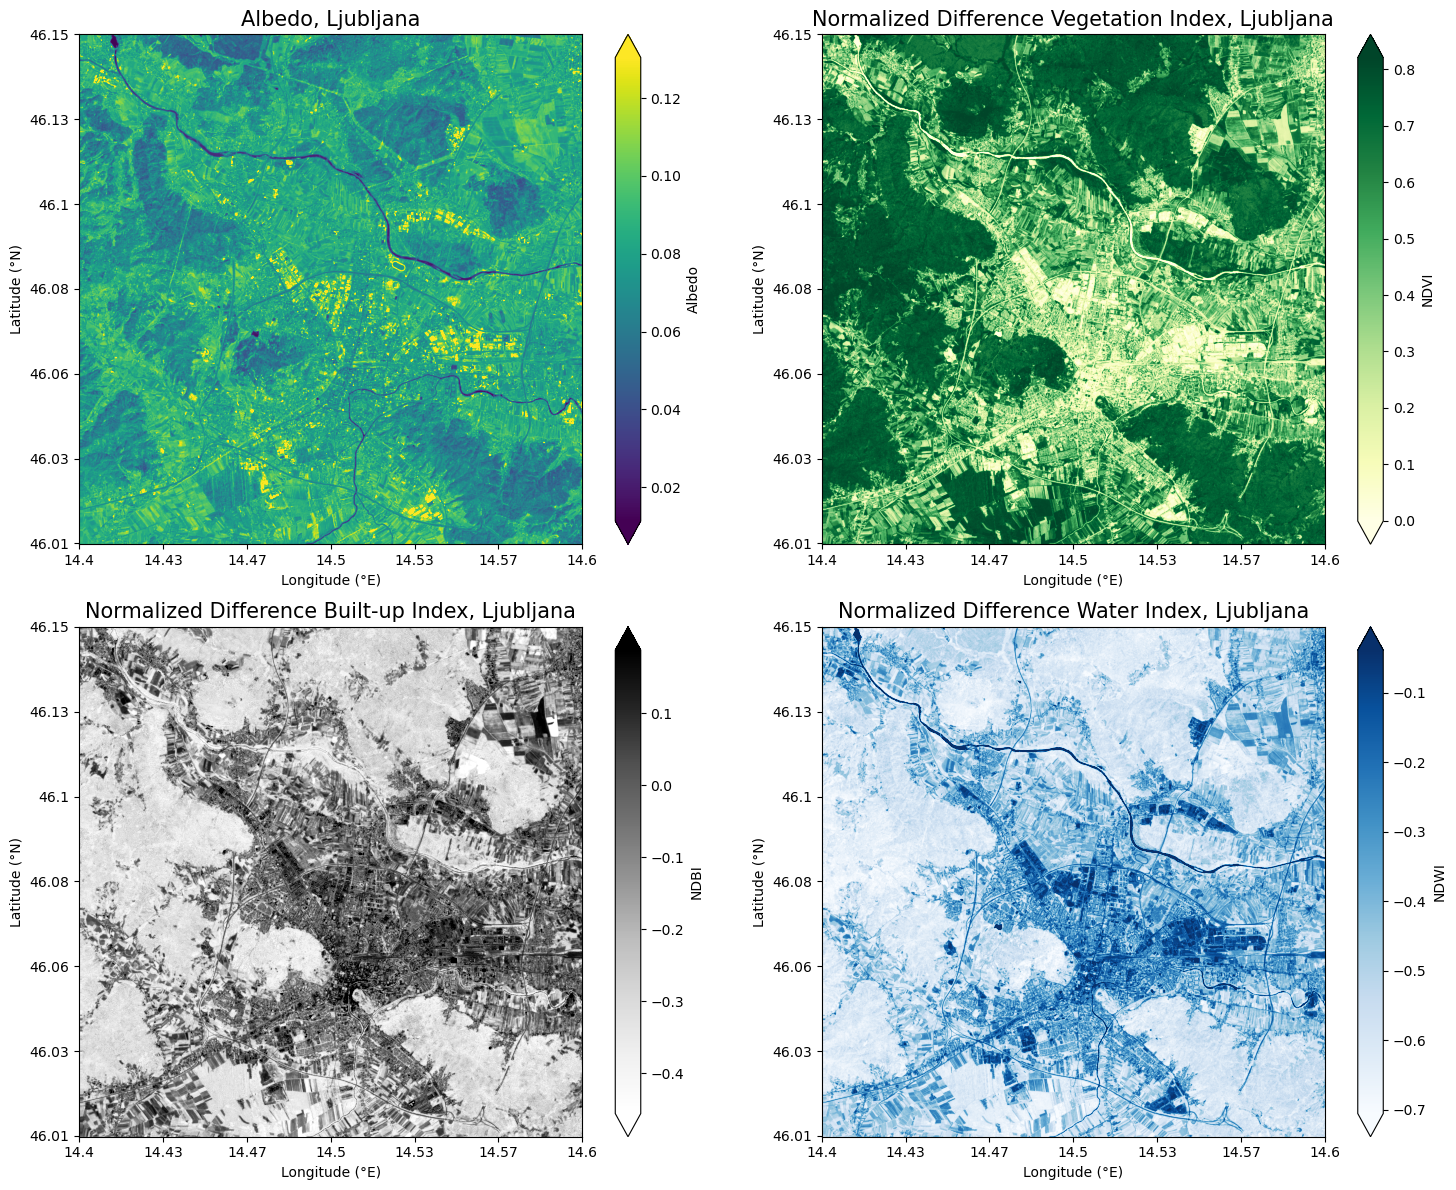

In [12]:
# Figure extent
plt.figure(figsize = (15,12))
plt.box(False)

# Plotting albedo data
plt.subplot(2,2,1)
plt.imshow(albedo)
plt.title("Albedo, "+city, fontsize = 15)
# colorbar
plt.colorbar(label = "Albedo", extend = "both")
plt.clim(np.nanmin(albedo),np.nanpercentile(albedo, 99))
# x-labels
xticks = [int(len(lon_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
xticks[len(xticks)-1] = xticks[len(xticks)-1]-1
xticklabels = lon_grid_clip_sentinel[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
yticks[len(yticks)-1] = yticks[len(yticks)-1]-1
yticklabels = lat_grid_clip_sentinel[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDVI data
plt.subplot(2,2,2)
plt.imshow(ndvi, cmap = "YlGn")
plt.title("Normalized Difference Vegetation Index, "+city, fontsize = 15)
# colorbar
plt.colorbar(label = "NDVI", extend = "both")
plt.clim(np.nanpercentile(ndvi,0.5),np.nanpercentile(ndvi, 99))
# x-labels
xticks = [int(len(lon_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
xticks[len(xticks)-1] = xticks[len(xticks)-1]-1
xticklabels = lon_grid_clip_sentinel[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
yticks[len(yticks)-1] = yticks[len(yticks)-1]-1
yticklabels = lat_grid_clip_sentinel[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDBI data
plt.subplot(2,2,3)
plt.imshow(ndbi, cmap = "Greys")
plt.title("Normalized Difference Built-up Index, "+city, fontsize = 15)
# colorbar
plt.colorbar(label = "NDBI", extend = "both")
plt.clim(np.nanpercentile(ndbi,0.5),np.nanpercentile(ndbi, 99))
# x-labels
xticks = [int(len(lon_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
xticks[len(xticks)-1] = xticks[len(xticks)-1]-1
xticklabels = lon_grid_clip_sentinel[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
yticks[len(yticks)-1] = yticks[len(yticks)-1]-1
yticklabels = lat_grid_clip_sentinel[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

# Plotting NDWI data
plt.subplot(2,2,4)
plt.imshow(ndwi, cmap = "Blues")
plt.title("Normalized Difference Water Index, "+city, fontsize = 15)
# colorbar
plt.colorbar(label = "NDWI", extend = "both")
plt.clim(np.nanpercentile(ndwi,0.5),np.nanpercentile(ndwi, 99))
# x-labels
xticks = [int(len(lon_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
xticks[len(xticks)-1] = xticks[len(xticks)-1]-1
xticklabels = lon_grid_clip_sentinel[xticks].round(2)
plt.xticks(xticks, xticklabels)
plt.xlabel("Longitude (\N{DEGREE SIGN}E)")
# y axis
yticks = [int(len(lat_grid_clip_sentinel)/6)*i for i in np.arange(0,7,1)]
yticks[len(yticks)-1] = yticks[len(yticks)-1]-1
yticklabels = lat_grid_clip_sentinel[yticks].round(2)
plt.yticks(yticks, yticklabels)
plt.ylabel("Latitude (\N{DEGREE SIGN}N)")

plt.tight_layout()